# Hello World
# Agor.Io Strategy

For this camp, we were asked to teach the machine the best strategy to win the game and guess what we went for clustering 

Algoithm:

Splitting the points into clusters
Each cluster becomes a sub problem

While traveled distance < 10000:
	Find the closest cluster
	While the cluster is not empty
Find the closest cell
		Delete the cell


This is the data: https://uncloud.univ-nantes.fr/index.php/s/XH68KiJsPdPnGms


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import io
from scipy.spatial.distance import euclidean 
from scipy.spatial.distance import pdist
import sys
import csv
import numpy as np
import sklearn.cluster as skc
import time
from concurrent.futures import ProcessPoolExecutor

In [16]:
df = pd.read_csv('data2.txt', header=None)
df.columns = ["id", "x", "y", "size"]
df = df.drop("id", axis=1)

In [25]:
df.size

15000

In [17]:
df.head()

,x,y,size
0,38.44,78.87,8
1,-109.76,-164.13,40
2,9.42,-88.62,86
3,97.66,-190.23,65
4,116.13,74.44,21


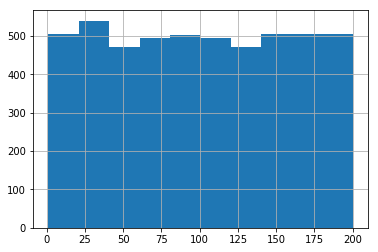

In [18]:
df["size"].hist()

In [6]:
def getClosest(current, points, n):
    ids = np.random.choice(points.index, n)
    scores = [euclidean([current.x, current.y], [points.T[i].x, points.T[i].y]) for i in ids]
    sample_min_id = scores.index(min(scores))
    m_id = ids[sample_min_id]
    return m_id, scores[sample_min_id]*points.T[m_id]["size"], points.T[m_id]["size"]

def baseline(points, limit=10000, n=50):
    results = []
    curr_point = pd.Series(data={"x":0, "y":0})
    traveled_dist = 0
    final_score = 0
    while traveled_dist<limit:
        target, d, size = getClosest(curr_point, points, n)
        traveled_dist += d
        final_score += size
        curr_point = points.T[target]
        points = points.drop(target)
        print("Next is {}, {} travelled with {} of score".format(target, int(traveled_dist), int(final_score)))
        results.append(target)
    return results[:len(results)-1]

res = baseline(df, n=1000)

Next is 8228, 55 travelled with 29 of score
Next is 8498, 191 travelled with 82 of score
Next is 220, 280 travelled with 163 of score
Next is 593, 465 travelled with 226 of score
Next is 8965, 644 travelled with 271 of score
Next is 1261, 815 travelled with 332 of score
Next is 9381, 828 travelled with 338 of score
Next is 3834, 893 travelled with 355 of score
Next is 2563, 1159 travelled with 452 of score
Next is 2246, 1642 travelled with 534 of score


KeyboardInterrupt: 

In [6]:
pd.DataFrame(res).to_csv("output.csv", header=False, index=False)

In [19]:
def getClosestCluster(current, clusters):
    dists = {label : euclidean([*current[["x", "y"]]], [*clusters.T[label].T[["mx", "my"]]]) for label in clusters.T}
    return min(dists, key=dists.get)

def getClosestPoint(current, points):
    dists = {i : euclidean([*current[["x", "y"]]], [*points.T[i].T[["x", "y"]]]) for i in points.T}
    m_id = min(dists, key=dists.get)
    return m_id, dists[m_id], points.T[m_id]["size"]

def clever_1(points, limit=10000, n_cells_per_clusters=100, quantile_size=0.5, log=True):
    n_clusters = int(len(points)/n_cells_per_clusters)
    min_size = df.quantile(q=quantile_size)["size"]
    points = points.loc[points['size'] > min_size].copy()
    points["label"] = skc.FeatureAgglomeration(n_clusters=n_clusters).fit(points[["x", "y"]].T).labels_
    
    results = []
    curr_point = pd.Series(data={"x":0, "y":0})
    traveled_dist = 0
    final_score = 0
    clusters = pd.DataFrame([[c["size"].mean(), *c[["x", "y"]].mean(), c] for label, c in points.groupby("label")], columns=["msize", "mx", "my", "points"])
    
    while traveled_dist<limit:
        curr_cluster = getClosestCluster(curr_point, clusters)
        points = clusters.T[curr_cluster]["points"]
        while len(points)>0:
            target, d, size = getClosestPoint(curr_point, points)
            traveled_dist += d
            final_score += size
            curr_point = points.T[target]
            points = points.drop(target)
            if(log):
                print("Next is {}, {:.2f} travelled with {} of score".format(target, traveled_dist, int(final_score)))
            if(traveled_dist<limit):
                results.append(target)
        clusters.drop(curr_cluster)
    return results, traveled_dist, final_score

In [14]:
result = {}
for q in np.arange(0.1,1,0.1):
    result[q] = {}
    for n in [20, 30, 40, 50, 75, 100, 150, 300, 500]:
        start = time.time()
        score = clever_1(df, limit=10000, n_cells_per_clusters=n, quantile_size=q, log=False)[2]
        duration = time.time()-start
        result[q][n] = {"score": score, "duration": duration}
        print("{:.1f}:{} -> {} in {:.2f} sec".format(q,n,score,duration))
pd.DataFrame(result).to_csv("gridresults2.csv", header=True, index=True)

0.1:20 -> 251376.0 in 1258.90 sec
0.1:30 -> 344905.0 in 581.19 sec
0.1:40 -> 344905.0 in 373.40 sec
0.1:50 -> 383520.0 in 381.24 sec
0.1:75 -> 383520.0 in 392.27 sec
0.1:100 -> 383520.0 in 379.03 sec
0.1:150 -> 280610.0 in 496.47 sec
0.1:300 -> 312932.0 in 1117.17 sec
0.1:500 -> 285404.0 in 2013.05 sec
0.2:20 -> 387940.0 in 494.14 sec
0.2:30 -> 387940.0 in 384.55 sec
0.2:40 -> 351819.0 in 291.48 sec
0.2:50 -> 351819.0 in 271.36 sec
0.2:75 -> 356445.0 in 697.46 sec
0.2:100 -> 356445.0 in 627.61 sec
0.2:150 -> 353954.0 in 585.94 sec
0.2:300 -> 310105.0 in 1415.49 sec
0.2:500 -> 288694.0 in 1431.87 sec
0.3:20 -> 347386.0 in 532.02 sec
0.3:30 -> 369684.0 in 314.82 sec
0.3:40 -> 369684.0 in 271.95 sec
0.3:50 -> 358470.0 in 293.59 sec
0.3:75 -> 358470.0 in 272.14 sec
0.3:100 -> 361080.0 in 484.24 sec
0.3:150 -> 361080.0 in 479.10 sec
0.3:300 -> 345950.0 in 1184.44 sec
0.3:500 -> 334536.0 in 2020.17 sec
0.4:20 -> 550536.0 in 733.03 sec
0.4:30 -> 550536.0 in 518.60 sec
0.4:40 -> 550536.0 in 41

KeyboardInterrupt: 

In [20]:
start = time.time()
result, _, _ = clever_1(df, limit=10000, quantile_size=0.7, n_cells_per_clusters=100)
print("{:.2f} sec".format(time.time()-start))

Next is 942, 3.61 travelled with 166 of score
Next is 4785, 9.79 travelled with 340 of score
Next is 852, 12.98 travelled with 516 of score
Next is 2451, 15.47 travelled with 666 of score
Next is 4289, 17.29 travelled with 845 of score
Next is 4140, 21.14 travelled with 1025 of score
Next is 941, 25.89 travelled with 1187 of score
Next is 3673, 30.37 travelled with 1378 of score
Next is 2372, 40.28 travelled with 1575 of score
Next is 2624, 40.50 travelled with 1740 of score
Next is 1587, 43.52 travelled with 1907 of score
Next is 1579, 52.54 travelled with 2101 of score
Next is 3626, 55.30 travelled with 2301 of score
Next is 3569, 56.58 travelled with 2445 of score
Next is 526, 62.88 travelled with 2599 of score
Next is 2108, 74.51 travelled with 2786 of score
Next is 661, 80.98 travelled with 2956 of score
Next is 1405, 93.97 travelled with 3153 of score
Next is 2638, 99.52 travelled with 3323 of score
Next is 235, 113.22 travelled with 3499 of score
Next is 4642, 116.34 travelled w

Next is 2149, 1293.73 travelled with 28379 of score
Next is 2783, 1299.06 travelled with 28533 of score
Next is 4174, 1301.78 travelled with 28683 of score
Next is 4718, 1304.38 travelled with 28871 of score
Next is 1091, 1317.26 travelled with 29029 of score
Next is 622, 1328.07 travelled with 29219 of score
Next is 1479, 1334.79 travelled with 29413 of score
Next is 1479, 1334.79 travelled with 29607 of score
Next is 622, 1341.50 travelled with 29797 of score
Next is 1091, 1352.32 travelled with 29955 of score
Next is 4174, 1362.71 travelled with 30105 of score
Next is 4718, 1365.31 travelled with 30293 of score
Next is 2783, 1368.06 travelled with 30447 of score
Next is 2149, 1373.40 travelled with 30642 of score
Next is 2368, 1380.33 travelled with 30818 of score
Next is 2751, 1385.58 travelled with 31013 of score
Next is 1753, 1393.41 travelled with 31155 of score
Next is 1917, 1401.25 travelled with 31311 of score
Next is 3070, 1402.54 travelled with 31502 of score
Next is 469, 1

Next is 527, 2304.56 travelled with 56408 of score
Next is 1917, 2315.01 travelled with 56564 of score
Next is 3070, 2316.30 travelled with 56755 of score
Next is 469, 2320.24 travelled with 56903 of score
Next is 1753, 2331.75 travelled with 57045 of score
Next is 2368, 2339.15 travelled with 57221 of score
Next is 2751, 2344.40 travelled with 57416 of score
Next is 2149, 2353.48 travelled with 57611 of score
Next is 2783, 2358.82 travelled with 57765 of score
Next is 4174, 2361.54 travelled with 57915 of score
Next is 4718, 2364.13 travelled with 58103 of score
Next is 1091, 2377.01 travelled with 58261 of score
Next is 622, 2387.83 travelled with 58451 of score
Next is 1479, 2394.54 travelled with 58645 of score
Next is 1479, 2394.54 travelled with 58839 of score
Next is 622, 2401.25 travelled with 59029 of score
Next is 1091, 2412.07 travelled with 59187 of score
Next is 4174, 2422.47 travelled with 59337 of score
Next is 4718, 2425.06 travelled with 59525 of score
Next is 2783, 24

Next is 527, 3364.32 travelled with 85640 of score
Next is 1917, 3374.77 travelled with 85796 of score
Next is 3070, 3376.06 travelled with 85987 of score
Next is 469, 3380.00 travelled with 86135 of score
Next is 1753, 3391.50 travelled with 86277 of score
Next is 2368, 3398.91 travelled with 86453 of score
Next is 2751, 3404.16 travelled with 86648 of score
Next is 2149, 3413.24 travelled with 86843 of score
Next is 2783, 3418.57 travelled with 86997 of score
Next is 4174, 3421.29 travelled with 87147 of score
Next is 4718, 3423.89 travelled with 87335 of score
Next is 1091, 3436.77 travelled with 87493 of score
Next is 622, 3447.58 travelled with 87683 of score
Next is 1479, 3454.30 travelled with 87877 of score
Next is 1479, 3454.30 travelled with 88071 of score
Next is 622, 3461.01 travelled with 88261 of score
Next is 1091, 3471.83 travelled with 88419 of score
Next is 4174, 3482.22 travelled with 88569 of score
Next is 4718, 3484.82 travelled with 88757 of score
Next is 2783, 34

Next is 469, 4409.11 travelled with 114474 of score
Next is 527, 4424.07 travelled with 114673 of score
Next is 527, 4424.07 travelled with 114872 of score
Next is 1917, 4434.52 travelled with 115028 of score
Next is 3070, 4435.81 travelled with 115219 of score
Next is 469, 4439.75 travelled with 115367 of score
Next is 1753, 4451.25 travelled with 115509 of score
Next is 2368, 4458.66 travelled with 115685 of score
Next is 2751, 4463.91 travelled with 115880 of score
Next is 2149, 4472.99 travelled with 116075 of score
Next is 2783, 4478.33 travelled with 116229 of score
Next is 4174, 4481.05 travelled with 116379 of score
Next is 4718, 4483.64 travelled with 116567 of score
Next is 1091, 4496.52 travelled with 116725 of score
Next is 622, 4507.34 travelled with 116915 of score
Next is 1479, 4514.05 travelled with 117109 of score
Next is 1479, 4514.05 travelled with 117303 of score
Next is 622, 4520.76 travelled with 117493 of score
Next is 1091, 4531.58 travelled with 117651 of score

Next is 622, 5403.89 travelled with 141853 of score
Next is 1091, 5414.71 travelled with 142011 of score
Next is 4174, 5425.11 travelled with 142161 of score
Next is 4718, 5427.70 travelled with 142349 of score
Next is 2783, 5430.46 travelled with 142503 of score
Next is 2149, 5435.79 travelled with 142698 of score
Next is 2368, 5442.72 travelled with 142874 of score
Next is 2751, 5447.98 travelled with 143069 of score
Next is 1753, 5455.81 travelled with 143211 of score
Next is 1917, 5463.64 travelled with 143367 of score
Next is 3070, 5464.93 travelled with 143558 of score
Next is 469, 5468.87 travelled with 143706 of score
Next is 527, 5483.83 travelled with 143905 of score
Next is 527, 5483.83 travelled with 144104 of score
Next is 1917, 5494.28 travelled with 144260 of score
Next is 3070, 5495.57 travelled with 144451 of score
Next is 469, 5499.51 travelled with 144599 of score
Next is 1753, 5511.01 travelled with 144741 of score
Next is 2368, 5518.42 travelled with 144917 of scor

Next is 1479, 6456.93 travelled with 170895 of score
Next is 622, 6463.65 travelled with 171085 of score
Next is 1091, 6474.46 travelled with 171243 of score
Next is 4174, 6484.86 travelled with 171393 of score
Next is 4718, 6487.45 travelled with 171581 of score
Next is 2783, 6490.21 travelled with 171735 of score
Next is 2149, 6495.55 travelled with 171930 of score
Next is 2368, 6502.48 travelled with 172106 of score
Next is 2751, 6507.73 travelled with 172301 of score
Next is 1753, 6515.56 travelled with 172443 of score
Next is 1917, 6523.39 travelled with 172599 of score
Next is 3070, 6524.68 travelled with 172790 of score
Next is 469, 6528.62 travelled with 172938 of score
Next is 527, 6543.58 travelled with 173137 of score
Next is 527, 6543.58 travelled with 173336 of score
Next is 1917, 6554.03 travelled with 173492 of score
Next is 3070, 6555.32 travelled with 173683 of score
Next is 469, 6559.26 travelled with 173831 of score
Next is 1753, 6570.76 travelled with 173973 of scor

Next is 1479, 7516.69 travelled with 200127 of score
Next is 622, 7523.40 travelled with 200317 of score
Next is 1091, 7534.22 travelled with 200475 of score
Next is 4174, 7544.62 travelled with 200625 of score
Next is 4718, 7547.21 travelled with 200813 of score
Next is 2783, 7549.97 travelled with 200967 of score
Next is 2149, 7555.30 travelled with 201162 of score
Next is 2368, 7562.23 travelled with 201338 of score
Next is 2751, 7567.49 travelled with 201533 of score
Next is 1753, 7575.32 travelled with 201675 of score
Next is 1917, 7583.15 travelled with 201831 of score
Next is 3070, 7584.44 travelled with 202022 of score
Next is 469, 7588.38 travelled with 202170 of score
Next is 527, 7603.34 travelled with 202369 of score
Next is 527, 7603.34 travelled with 202568 of score
Next is 1917, 7613.79 travelled with 202724 of score
Next is 3070, 7615.08 travelled with 202915 of score
Next is 469, 7619.01 travelled with 203063 of score
Next is 1753, 7630.52 travelled with 203205 of scor

Next is 3070, 8498.21 travelled with 227275 of score
Next is 469, 8502.14 travelled with 227423 of score
Next is 1753, 8513.65 travelled with 227565 of score
Next is 2368, 8521.05 travelled with 227741 of score
Next is 2751, 8526.31 travelled with 227936 of score
Next is 2149, 8535.38 travelled with 228131 of score
Next is 2783, 8540.72 travelled with 228285 of score
Next is 4174, 8543.44 travelled with 228435 of score
Next is 4718, 8546.03 travelled with 228623 of score
Next is 1091, 8558.91 travelled with 228781 of score
Next is 622, 8569.73 travelled with 228971 of score
Next is 1479, 8576.44 travelled with 229165 of score
Next is 1479, 8576.44 travelled with 229359 of score
Next is 622, 8583.16 travelled with 229549 of score
Next is 1091, 8593.97 travelled with 229707 of score
Next is 4174, 8604.37 travelled with 229857 of score
Next is 4718, 8606.96 travelled with 230045 of score
Next is 2783, 8609.72 travelled with 230199 of score
Next is 2149, 8615.06 travelled with 230394 of sc

Next is 527, 9546.22 travelled with 256160 of score
Next is 1917, 9556.67 travelled with 256316 of score
Next is 3070, 9557.96 travelled with 256507 of score
Next is 469, 9561.90 travelled with 256655 of score
Next is 1753, 9573.40 travelled with 256797 of score
Next is 2368, 9580.81 travelled with 256973 of score
Next is 2751, 9586.06 travelled with 257168 of score
Next is 2149, 9595.14 travelled with 257363 of score
Next is 2783, 9600.48 travelled with 257517 of score
Next is 4174, 9603.19 travelled with 257667 of score
Next is 4718, 9605.79 travelled with 257855 of score
Next is 1091, 9618.67 travelled with 258013 of score
Next is 622, 9629.48 travelled with 258203 of score
Next is 1479, 9636.20 travelled with 258397 of score
Next is 1479, 9636.20 travelled with 258591 of score
Next is 622, 9642.91 travelled with 258781 of score
Next is 1091, 9653.73 travelled with 258939 of score
Next is 4174, 9664.12 travelled with 259089 of score
Next is 4718, 9666.72 travelled with 259277 of sco

In [7]:
pd.DataFrame(result).to_csv("output.csv", header=False, index=False)

In [22]:
clustering = skc.FeatureAgglomeration(n_clusters=100).fit(df[["x", "y"]].T)

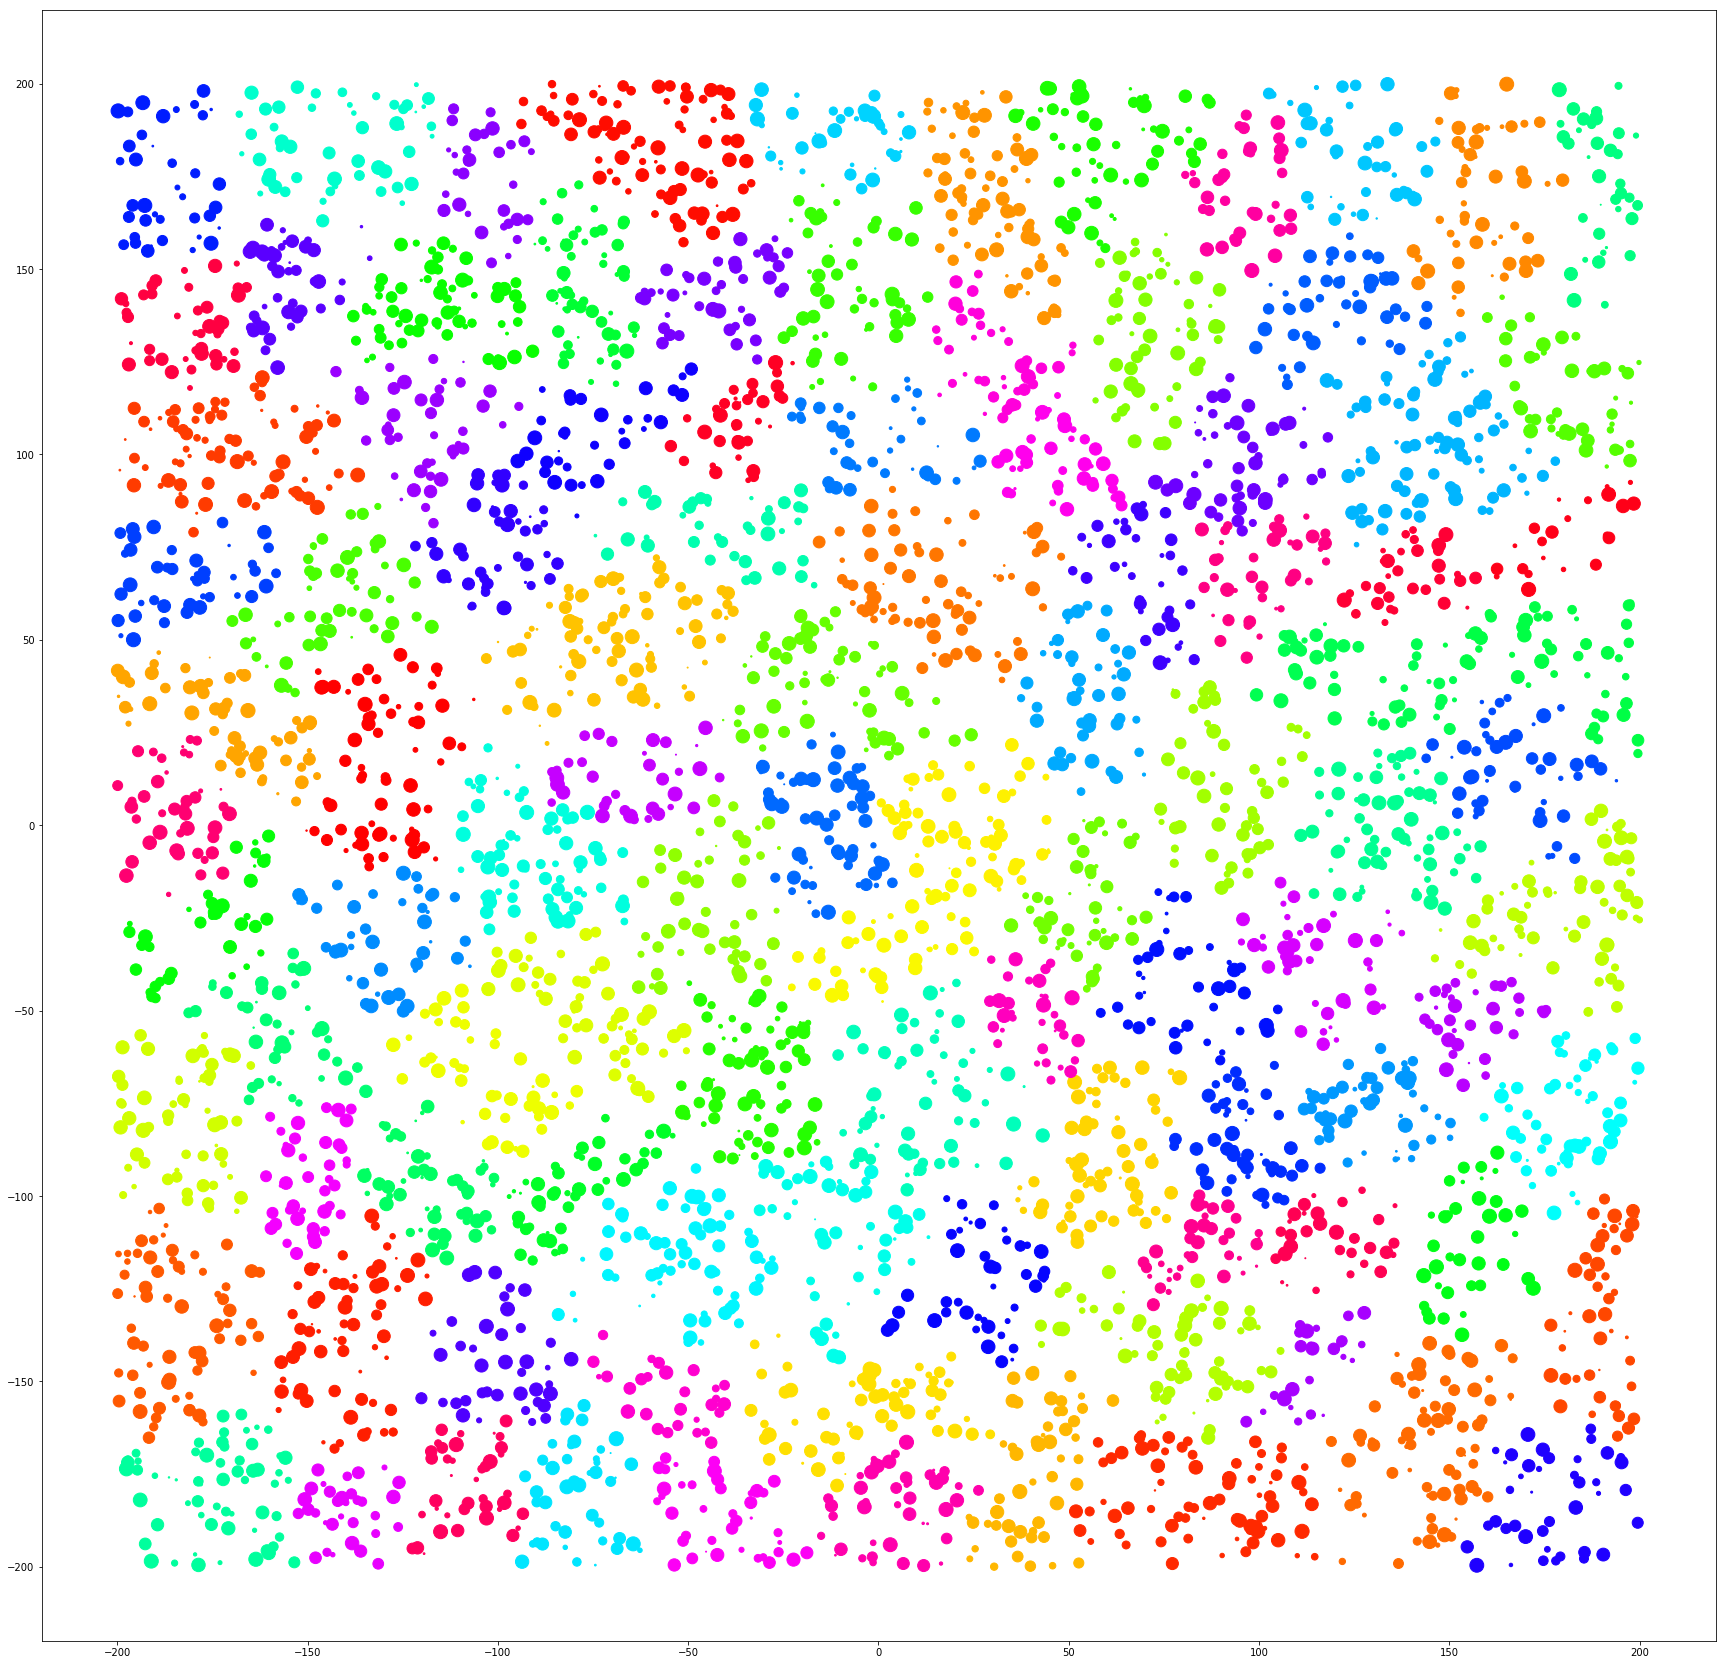

In [23]:
plt.figure(figsize=(30, 30))
plt.scatter(x=df["x"], y=df["y"], s=df["size"], c=clustering.labels_, cmap="hsv")

plt.show()